In [1]:
# step 1: import modules
import pybamm;from pybamm import constants,exp,tanh,sqrt;
import numpy as np
import matplotlib.pyplot as plt;import matplotlib as mpl;
import pandas as pd   ;import numpy as np;import os;import os;
from scipy.io import savemat,loadmat; 
import traceback;import imageio.v2 as imageio
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    may_cause_error,
)
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
def electrolyte_conductivity_Nyman2008Exp_wEC(c_e,c_EC, T):
    x = c_EC / c_e
    coff = 1  
    ratio = ( coff/2 + coff/2 *  tanh((x-4.541*0.5)*1.5))
    sigma_e = (
        ratio * (
        0.1 * 0.06248 * (1+298.15-0.05559) * 
        (c_e/1e3) * (1 - 3.084 *sqrt(c_e/1e3) 
        + 1.33 *(1+ 0.03633 *(exp(1000/298.15))*c_e/1e3)   ) 
        / (1+(c_e/1e3)**4*( 0.00795 *exp(1000/298.15))) )
    )
    return sigma_e

In [3]:
# Step 2: model parameters
De = 3e-10;Dec = 5e-10; Dcross  = 3e-11; Xi=-1.4; t_0plus=0.28
D_ec_sei=5e-21; # 
model_0 = pybamm.lithium_ion.DFN(     
    options={
        "SEI":"solvent-diffusion limited",          
        "SEI film resistance":"distributed",          
        "SEI porosity change":"true",     
        "solvent diffusion": "EC wo refill"     } )
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008Exp";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0['EC transference number'] =    Xi
Para_0['Cation transference number'] =     t_0plus
Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = Dcross
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  Dec
Para_0['Ratio of lithium moles to SEI moles'] =  1
Para_0['EC diffusivity in SEI [m2.s-1]'] =  D_ec_sei
Para_0.update({
    'Electrolyte conductivity [S.m-1]':
    electrolyte_conductivity_Nyman2008Exp_wEC}, )
Para_0['Ratio of lithium moles to SEI moles'] =  1

c_e = model_0.variables["Electrolyte concentration [mol.m-3]"]
T = model_0.variables["Cell temperature [K]"]
c_EC = model_0.variables["EC concentration [mol.m-3]"]
model_0.variables["c(EC) over c(Li+)"] = c_EC / c_e
model_0.variables["Electrolyte conductivity [S.m-1]"] =(
    Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
model_0.variables["Electrolyte diffusivity [m2.s-1]"] =(
    Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))

Confirm: using solvent-diffusion limited
using EC wo refill for Li+


In [4]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R7/'; 
Target  = 'a4_2_run_to_fail/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [5]:
# Report two bugs here (may be ): dynamic plot cannot sincerely refelct what is in the 

In [6]:
# Plot a pair of loc dependent varibles - within one step
def Plot_Loc_Var_sol( sol,x_loc_all, key_all, cycle, step,colormap  ): # for initial solution object
    Num_subplot = len(key_all); # must have 2+ keys
    fig, axs = plt.subplots(1,Num_subplot, figsize=(7*Num_subplot,5),tight_layout=True)
    for i in range(0,Num_subplot):
        x_loc=x_loc_all[i]; key=key_all[i];
        LinesNmum = len(sol.cycles[cycle].steps[step][key].entries[0,:] )
        cmap_i = mpl.cm.get_cmap(colormap, LinesNmum) 
        for j in range(0,LinesNmum):
            axs[i].plot(
                sol.cycles[cycle].steps[step][x_loc].entries[:,0], 
                sol.cycles[cycle].steps[step][key].entries[:,j], '-',
                color=cmap_i(j),)
            axs[i].set_title(key ,   fontdict={'family':'DejaVu Sans','size':fs-1})
            #axs[1].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
            axs[i].set_xlabel(x_loc,   fontdict={'family':'DejaVu Sans','size':fs})
            
            labels = axs[i].get_xticklabels() + axs[i].get_yticklabels(); [label.set_fontname('DejaVu Sans') for label in labels]
            
            axs[i].tick_params(labelcolor='k', labelsize=fs, width=1) ;  del labels;
            axs[i].ticklabel_format( axis='x', style='sci',scilimits=[-0.01,0.01], useOffset=None, useLocale=None, useMathText=None)
            #axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},loc='best',frameon=False)  
    return 

In [7]:
# Step 3: run set up model_0 and parameters:
V_max = 4.2;        V_min = 2.5; 
exp_text_1 = [ (
    f"Discharge at 1C until {V_min} V",  
    "Rest for 1 hours",  
    f"Charge at 1C until {V_max} V" ) ]
exp_text_2 = [ (
    f"Discharge at 1C until {V_min} V (1 minute period)",  
    "Rest for 1 hours (1 minute period)",  
    f"Charge at 1C until {V_max} V (1 minute period)" ) ]
exp_text_CD = [ (f"Discharge at 1C until {V_min} V (10 second period)",   ) ]
exp_text_RE = [ ("Rest for 1 hours (10 second period)", ) ]
exp_text_CC = [ (f"Charge at 1C until {V_max} V (10 second period)" ) ]
# further Steps if we can catch the seconds information:
ExpList     = [
    exp_text_1,exp_text_1,exp_text_1,
    exp_text_CD,exp_text_RE,exp_text_CC];
SaveAsList  = [
    100,       10,  1, 
    1, 1,1];
Succ_Cyc = []; Sol_All = [];    # contains all solutions and corresponding cycles
tot_target_cyc = 200
i = 0;step_switch = 0
while (i < tot_target_cyc):
    print('try to run %d cycles' % SaveAsList[step_switch])
    expe_i    = pybamm.Experiment( 
        ExpList[step_switch] * 
        SaveAsList[step_switch]) 
    # inherit previous resuls or run model from scratch
    try:   # run the model
        if i == 0: # first time or never succeed, run model from scratch:
            sim_0    = pybamm.Simulation(
                model_0,        experiment = expe_i,
                parameter_values = Para_0,
                solver = pybamm.CasadiSolver(),
                #var_pts=var_pts,
                #submesh_types=submesh_types
                ) #mode="safe"
            sol_0    = sim_0.solve(
                calc_esoh=False,
                save_at_cycles = SaveAsList[step_switch])
            if step_switch < 3: # 0,1,2, which make last step 2
                print(sol_0.cycles[SaveAsList[step_switch]-1].steps[2]["Terminal voltage [V]"].entries[-1])
            else: 
                print(sol_0.cycles[SaveAsList[step_switch]-1].steps[-1]["Terminal voltage [V]"].entries[-1])
        else: # succeeded before, 
            model_new = model_old.set_initial_conditions_from(
                sol_old, inplace=False)
            sim_new    = pybamm.Simulation(
                model_new,        experiment = expe_i,
                parameter_values = Para_0,
                solver = pybamm.CasadiSolver(),
                #var_pts=var_pts,
                #submesh_types=submesh_types
                ) #mode="safe"
            sol_new    = sim_new.solve(
                calc_esoh=False,
                save_at_cycles = SaveAsList[step_switch])   
            if step_switch < 3: # 0,1,2, which make last step 2
                print(sol_new.cycles[SaveAsList[step_switch]-1].steps[2]["Terminal voltage [V]"].entries[-1])
            else: 
                print(sol_new.cycles[SaveAsList[step_switch]-1].steps[-1]["Terminal voltage [V]"].entries[-1])
    except:
        print('Failed and shorten cycles')
        step_switch += 1
        if (step_switch >= len(SaveAsList)):
            print('Exit as no options left')
            break
    else:        
        if i == 0: 
            model_old = model_0; sol_old = sol_0    
        else: 
            model_old = model_new; sol_old = sol_new
            del model_new,sol_new
        Sol_All.append(sol_old);
        Succ_Cyc.append(SaveAsList[step_switch])
        i += SaveAsList[step_switch]
        print('Succeed! Now it is the %dth cycles' % i)    



try to run 100 cycles
4.199990000000012
Succeed! Now it is the 100th cycles
try to run 100 cycles


2022-10-24 22:42:55.322 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Rest for 1 hours'. The returned solution only contains up to step 2 of cycle 50. 


Failed and shorten cycles
try to run 10 cycles
4.199989999999999
Succeed! Now it is the 110th cycles
try to run 10 cycles
4.199989999999999
Succeed! Now it is the 120th cycles
try to run 10 cycles
4.199990000000002
Succeed! Now it is the 130th cycles
try to run 10 cycles
4.1999900000000014
Succeed! Now it is the 140th cycles
try to run 10 cycles


2022-10-24 22:45:48.928 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Rest for 1 hours'. The returned solution only contains up to step 2 of cycle 10. 


Failed and shorten cycles
try to run 1 cycles
4.19999
Succeed! Now it is the 141th cycles
try to run 1 cycles
4.199990000000001
Succeed! Now it is the 142th cycles
try to run 1 cycles
4.199990000000001
Succeed! Now it is the 143th cycles
try to run 1 cycles
4.199990000000001
Succeed! Now it is the 144th cycles
try to run 1 cycles
4.19999
Succeed! Now it is the 145th cycles
try to run 1 cycles
4.19999
Succeed! Now it is the 146th cycles
try to run 1 cycles
4.199990000000001
Succeed! Now it is the 147th cycles
try to run 1 cycles
4.19999
Succeed! Now it is the 148th cycles
try to run 1 cycles
4.199990000000001
Succeed! Now it is the 149th cycles
try to run 1 cycles


2022-10-24 22:46:48.486 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Rest for 1 hours'. The returned solution only contains up to step 2 of cycle 1. 


Failed and shorten cycles
try to run 1 cycles
2.500009999999999
Succeed! Now it is the 150th cycles
try to run 1 cycles
2.5000100000000005
Succeed! Now it is the 151th cycles
try to run 1 cycles
2.50001
Succeed! Now it is the 152th cycles
try to run 1 cycles
2.5000100000000005
Succeed! Now it is the 153th cycles
try to run 1 cycles
2.5000099999996936
Succeed! Now it is the 154th cycles
try to run 1 cycles
2.5000099999997576
Succeed! Now it is the 155th cycles
try to run 1 cycles
2.5000099999992464
Succeed! Now it is the 156th cycles
try to run 1 cycles
2.5000099999984804
Succeed! Now it is the 157th cycles
try to run 1 cycles
2.500009999996995
Succeed! Now it is the 158th cycles
try to run 1 cycles
2.500009999994107
Succeed! Now it is the 159th cycles
try to run 1 cycles
2.5000099999881154
Succeed! Now it is the 160th cycles
try to run 1 cycles
2.500009999976395
Succeed! Now it is the 161th cycles
try to run 1 cycles
2.5000099999524936
Succeed! Now it is the 162th cycles
try to run 1 c

2022-10-24 22:47:19.022 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076778042976
Succeed! Now it is the 181th cycles
try to run 1 cycles


2022-10-24 22:47:19.920 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076778042967
Succeed! Now it is the 182th cycles
try to run 1 cycles


2022-10-24 22:47:20.832 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076778042976
Succeed! Now it is the 183th cycles
try to run 1 cycles


2022-10-24 22:47:21.890 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076778042976
Succeed! Now it is the 184th cycles
try to run 1 cycles


2022-10-24 22:47:22.828 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076778039823
Succeed! Now it is the 185th cycles
try to run 1 cycles


2022-10-24 22:47:23.788 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307677803608
Succeed! Now it is the 186th cycles
try to run 1 cycles


2022-10-24 22:47:24.683 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076778032123
Succeed! Now it is the 187th cycles
try to run 1 cycles


2022-10-24 22:47:25.617 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307677801727
Succeed! Now it is the 188th cycles
try to run 1 cycles


2022-10-24 22:47:27.001 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076777994126
Succeed! Now it is the 189th cycles
try to run 1 cycles


2022-10-24 22:47:28.178 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307677794505
Succeed! Now it is the 190th cycles
try to run 1 cycles


2022-10-24 22:47:29.140 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076777848922
Succeed! Now it is the 191th cycles
try to run 1 cycles


2022-10-24 22:47:30.094 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076777655393
Succeed! Now it is the 192th cycles
try to run 1 cycles


2022-10-24 22:47:31.028 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076777265136
Succeed! Now it is the 193th cycles
try to run 1 cycles


2022-10-24 22:47:31.962 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076776486923
Succeed! Now it is the 194th cycles
try to run 1 cycles


2022-10-24 22:47:32.888 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307677493246
Succeed! Now it is the 195th cycles
try to run 1 cycles


2022-10-24 22:47:33.797 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076771825114
Succeed! Now it is the 196th cycles
try to run 1 cycles


2022-10-24 22:47:34.711 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307676560711
Succeed! Now it is the 197th cycles
try to run 1 cycles


2022-10-24 22:47:35.638 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307675317795
Succeed! Now it is the 198th cycles
try to run 1 cycles


2022-10-24 22:47:36.538 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.4743076728321354
Succeed! Now it is the 199th cycles
try to run 1 cycles


2022-10-24 22:47:37.483 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Minimum voltage' was triggered during 'Discharge at 1C until 2.5 V (10 second period)'. The returned solution only contains up to step 1 of cycle 1. 


2.474307667862104
Succeed! Now it is the 200th cycles


In [10]:
# Sol_All[-1] contains the 140th to 150th cycles, 
# among which the 150th cycles only contains the first 2 cycles

print("voltage of the final 2 steps (discharge and rest)")
print(Sol_All[-1].cycles[-1].steps[0]["Terminal voltage [V]"].entries)
print(Sol_All[-1].cycles[-1].steps[-1]["Terminal voltage [V]"].entries)
print ("current is")
print(Sol_All[-1].cycles[-1].steps[0]["Current [A]"].entries)
print(Sol_All[-1].cycles[-1].steps[-1]["Current [A]"].entries)
print("Porosity times concentration") 
print(Sol_All[-1].cycles[-1].steps[0]["Porosity times concentration"].entries)
print(Sol_All[-1].cycles[-1].steps[-1]["Porosity times concentration"].entries)


voltage of the final 2 steps (discharge and rest)
[2.47430766 2.47430767]
[2.47430766 2.47430767]
current is
[5. 5.]
[5. 5.]
Porosity times concentration
[[1.23632664 1.23632664]
 [0.94317183 0.94317183]
 [0.76758923 0.76758923]
 [0.65596086 0.65596086]
 [0.57607985 0.57607985]
 [0.51449937 0.51449937]
 [0.46458841 0.46458841]
 [0.42267437 0.42267437]
 [0.38654184 0.38654184]
 [0.35476571 0.35476571]
 [0.32638228 0.32638228]
 [0.30071323 0.30071323]
 [0.27726531 0.27726531]
 [0.25566988 0.25566988]
 [0.23564478 0.23564478]
 [0.21696935 0.21696935]
 [0.19946768 0.19946768]
 [0.18299718 0.18299718]
 [0.16744055 0.16744055]
 [0.15270004 0.15270004]
 [0.31943741 0.31943741]
 [0.31811624 0.31811624]
 [0.31679971 0.31679971]
 [0.31548778 0.31548778]
 [0.31418042 0.31418042]
 [0.31287759 0.31287759]
 [0.31157927 0.31157927]
 [0.31028543 0.31028542]
 [0.30899602 0.30899602]
 [0.30771104 0.30771104]
 [0.30643043 0.30643043]
 [0.30515418 0.30515418]
 [0.30388226 0.30388226]
 [0.30261463 0.302614

In [11]:
Sol_All[0].cycles[99].steps

In [12]:
print(len(Sol_All))
print(Succ_Cyc)
print(Sol_All)

65
[100, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[<pybamm.solvers.solution.Solution object at 0x0000024E9DEA43A0>, <pybamm.solvers.solution.Solution object at 0x0000024E9E4D5EE0>, <pybamm.solvers.solution.Solution object at 0x0000024EA3375CD0>, <pybamm.solvers.solution.Solution object at 0x0000024E9161CC40>, <pybamm.solvers.solution.Solution object at 0x0000024EA5950400>, <pybamm.solvers.solution.Solution object at 0x0000024EA6F41AF0>, <pybamm.solvers.solution.Solution object at 0x0000024EAA579610>, <pybamm.solvers.solution.Solution object at 0x0000024EABADF730>, <pybamm.solvers.solution.Solution object at 0x0000024EA8023820>, <pybamm.solvers.solution.Solution object at 0x0000024EAE010B50>, <pybamm.solvers.solution.Solution object at 0x0000024EAF53DB50>, <pybamm.solvers.solution.Solution object at 0x0000024EB0AB41F0>, <pybamm.solver

In [15]:
Sol_All[5].cycles

In [22]:
output_variables3 = [
    "Terminal voltage [V]",
    "Current [A]",
    "Electrolyte concentration",
    "Minus div Li+ flux",
    "Li+ source term",
    "Minus div Li+ flux by diffusion",
    "Minus div Li+ flux by migration",
    "Minus div Li+ flux by solvent",
    "EC concentration",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
]
quick_plot = pybamm.QuickPlot(
    Sol_All[-1].cycles[-1] ,
    output_variables3,
    variable_limits='tight',time_unit='hours',n_rows=3,
    figsize = (16,12)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=4.013499927049785e-10, step=4.01349992704978…

In [ ]:
output_variables3 = [
    "Terminal voltage [V]",
    "Discharge capacity [A.h]",
    #"Negative electrode potential [V]",
    "Negative electrode porosity",
    "Porosity times concentration",
    "Electrolyte potential [V]",
    "Electrolyte current density [A.m-2]",
    'Electrolyte conductivity [S.m-1]',
    "Electrolyte concentration [mol.m-3]",
    #"Sum of positive electrode interfacial current densities",

    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    Sol_All[-1].cycles[-1] ,
    output_variables3,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (16,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=19.85577016023288, description='t', max=20.63757573051563, min=19.8557…

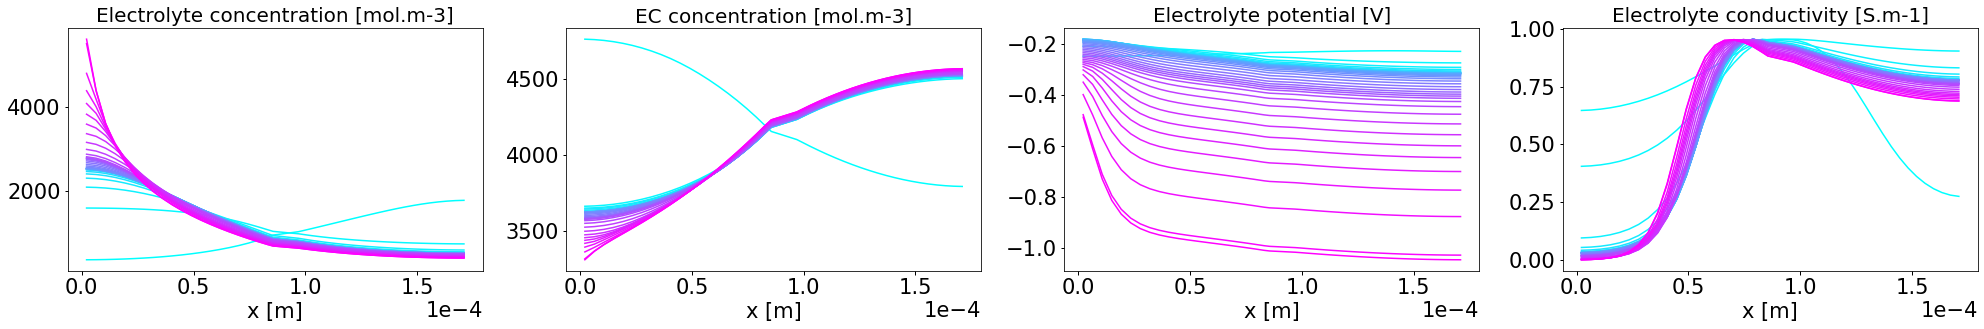

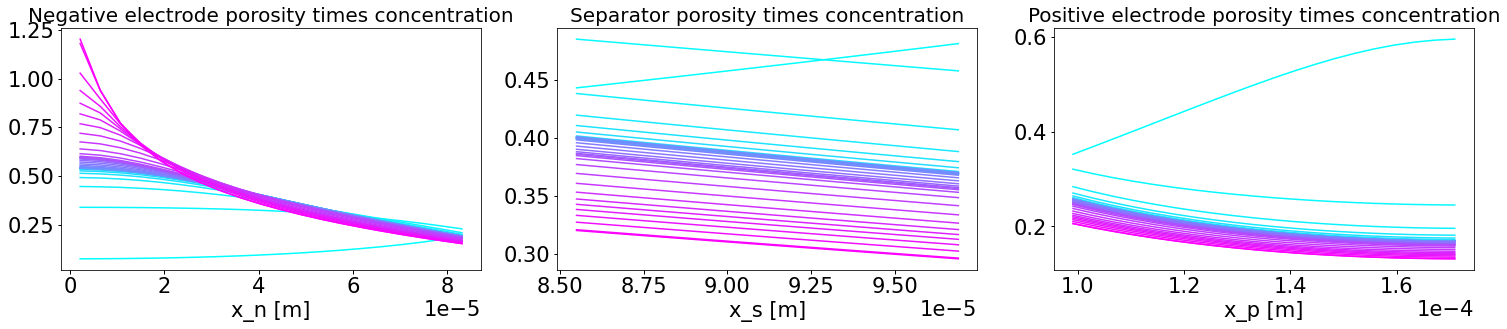

In [ ]:
# PLOT for discharge step of the last solution
fs = 21
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]","x [m]"], 
    [
        "Electrolyte concentration [mol.m-3]",
        "EC concentration [mol.m-3]",
        "Electrolyte potential [V]",
        "Electrolyte conductivity [S.m-1]",],
    -1,0,'cool')
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x_n [m]","x_s [m]","x_p [m]"], 
    [
        "Negative electrode porosity times concentration",
        "Separator porosity times concentration",
        "Positive electrode porosity times concentration",],
    -1,0,'cool')


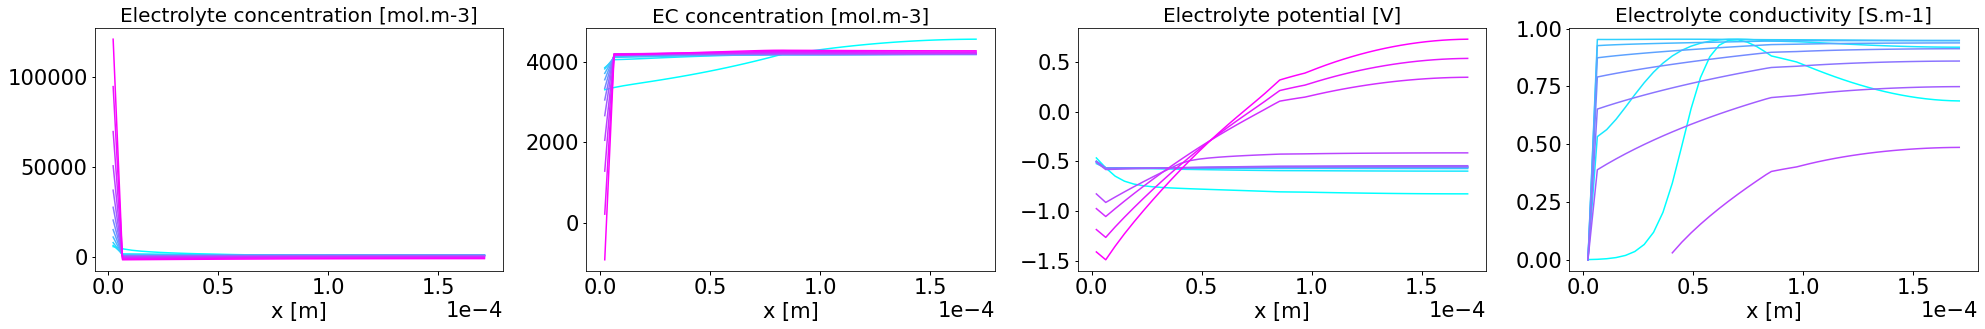

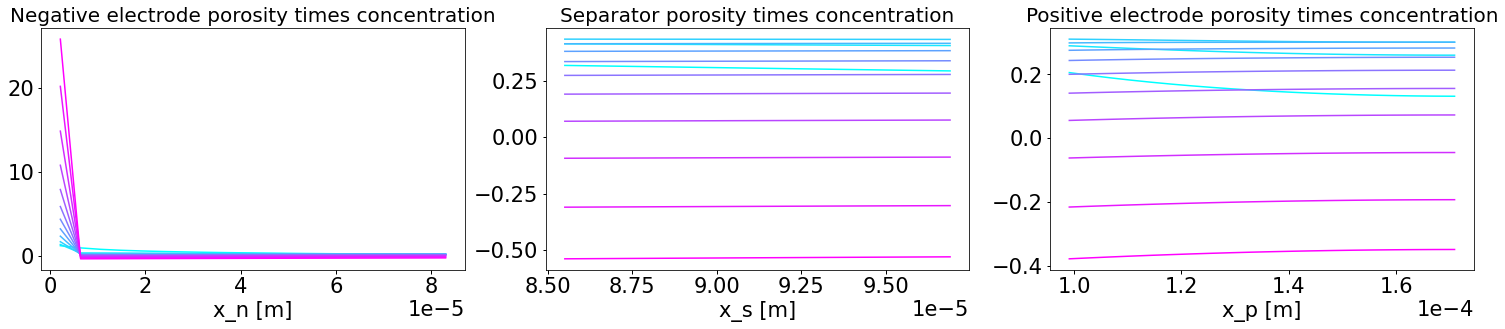

In [ ]:
# PLOT for rest step of the last solution
fs = 21
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]","x [m]"], 
    [
        "Electrolyte concentration [mol.m-3]",
        "EC concentration [mol.m-3]",
        "Electrolyte potential [V]",
        "Electrolyte conductivity [S.m-1]",],
    -1,1,'cool')
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x_n [m]","x_s [m]","x_p [m]"], 
    [
        "Negative electrode porosity times concentration",
        "Separator porosity times concentration",
        "Positive electrode porosity times concentration",],
    -1,1,'cool')
# some wired things happen during rest, making electrolyte concentration very high 

c(Li+) and flux
Li+ flux breakdown
c(EC) and flux
EC flux breakdown


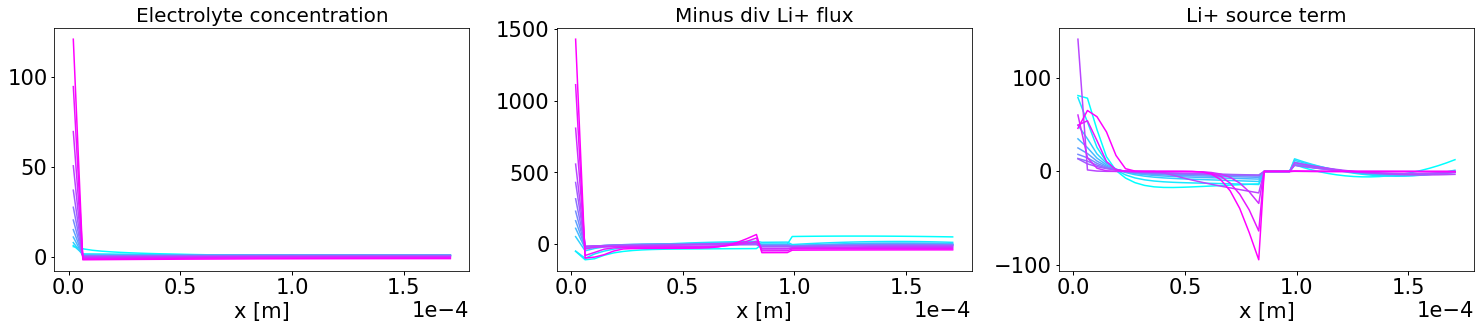

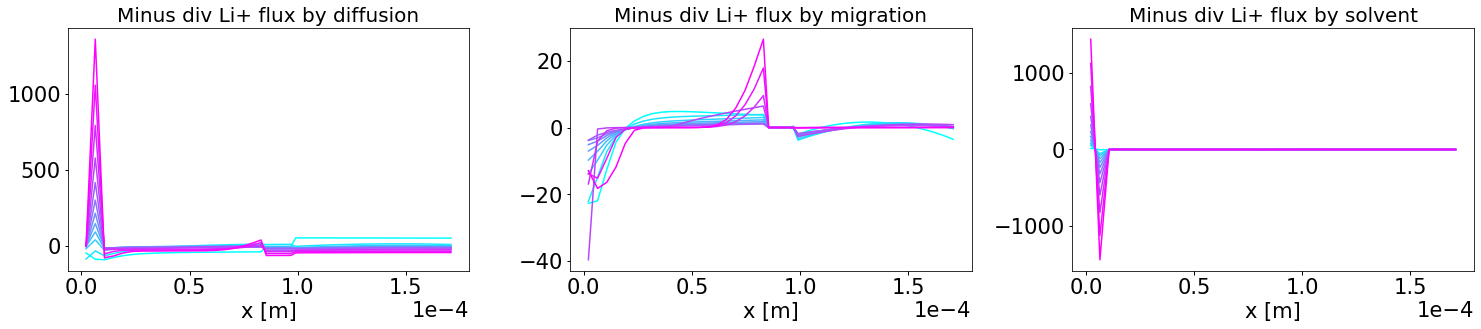

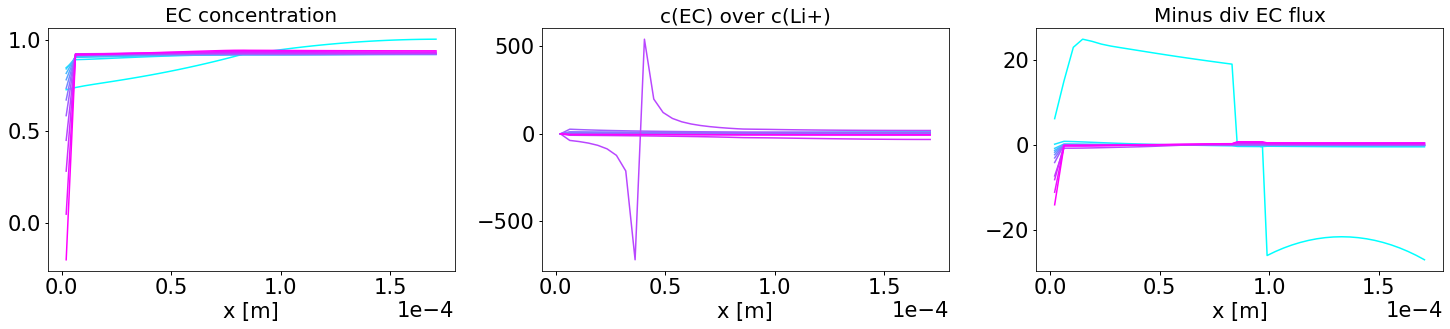

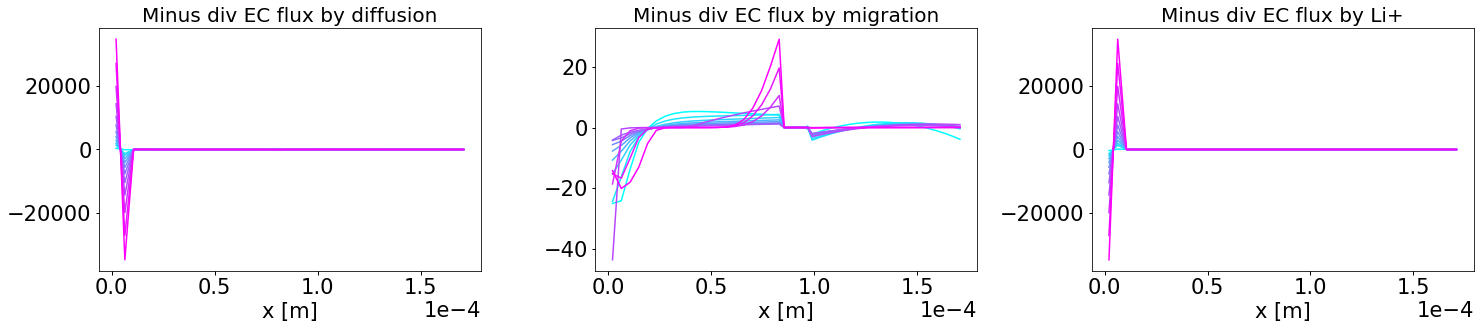

In [ ]:
# analyse the flux contribution for the rest period:
print("c(Li+) and flux")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["Electrolyte concentration",
        "Minus div Li+ flux",
        "Li+ source term",],
    -1,1,'cool')
print("Li+ flux breakdown")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["Minus div Li+ flux by diffusion",
        "Minus div Li+ flux by migration",
        "Minus div Li+ flux by solvent",],
    -1,1,'cool')
print("c(EC) and flux")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["EC concentration",
        "c(EC) over c(Li+)",
        "Minus div EC flux",], 
    -1,1,'cool')
print("EC flux breakdown")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["Minus div EC flux by diffusion",
        "Minus div EC flux by migration",
        "Minus div EC flux by Li+",], 
    -1,1,'cool')

c(Li+) and flux
Li+ flux breakdown
c(EC) and flux
EC flux breakdown


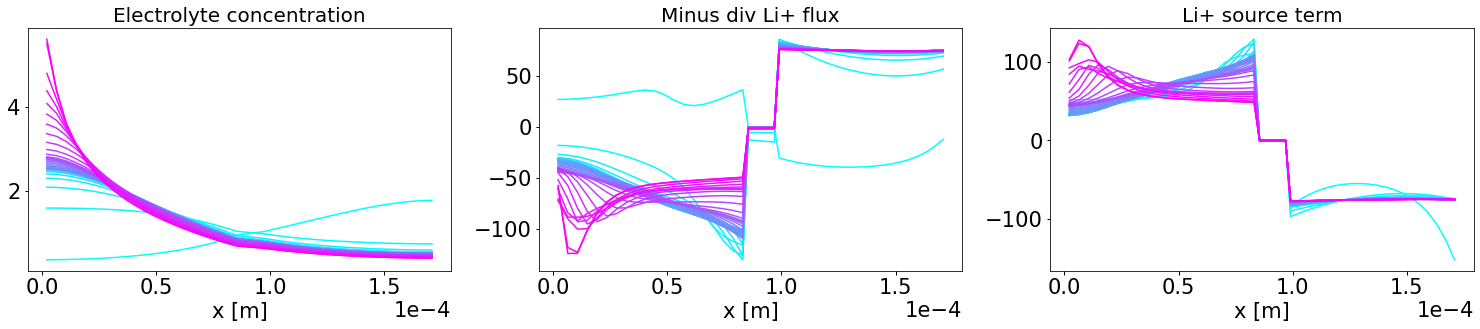

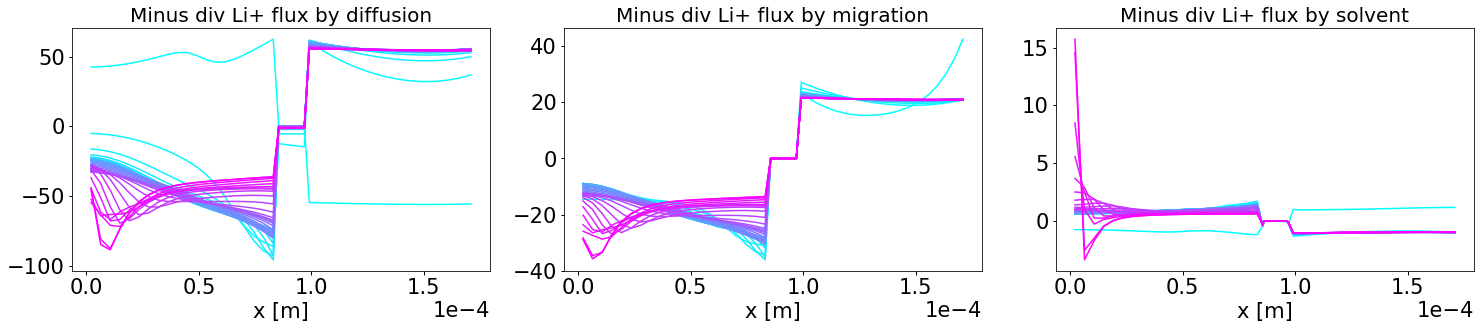

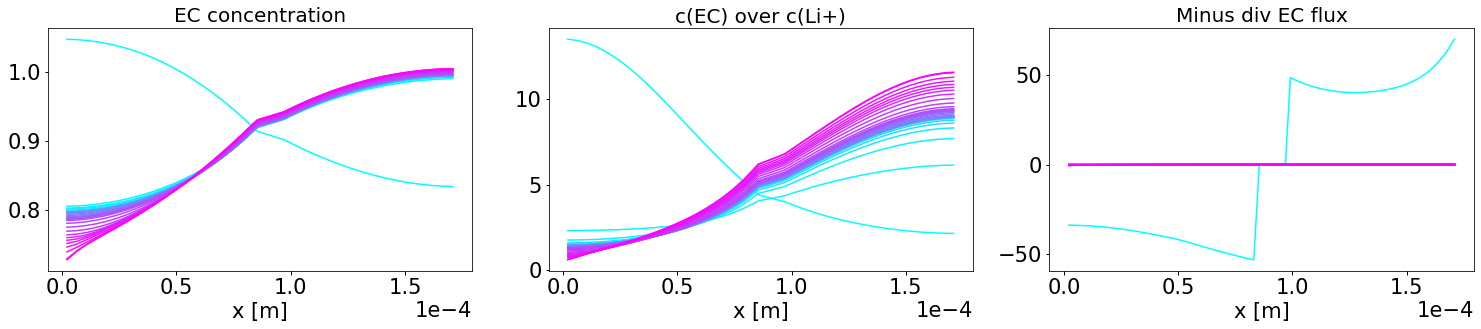

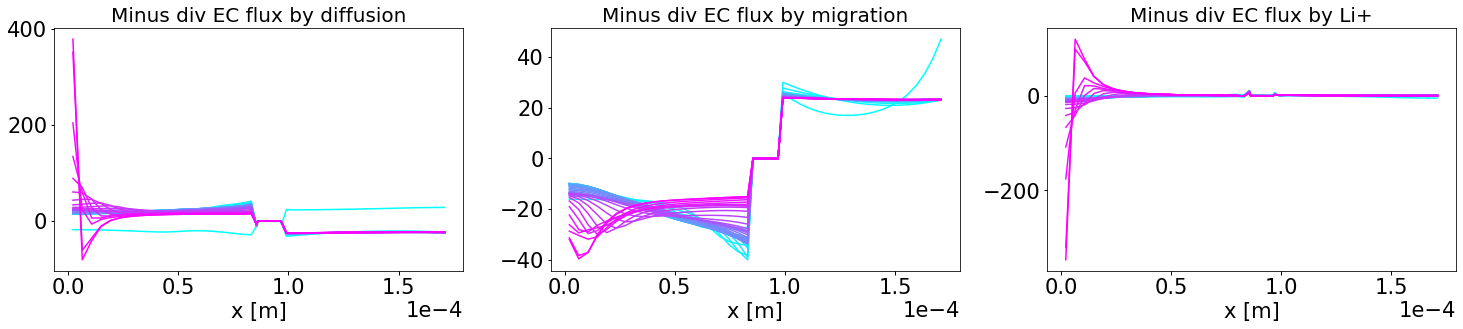

In [ ]:
# analyse the flux contribution for the discharge period:
print("c(Li+) and flux")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["Electrolyte concentration",
        "Minus div Li+ flux",
        "Li+ source term",],
    -1,0,'cool')
print("Li+ flux breakdown")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["Minus div Li+ flux by diffusion",
        "Minus div Li+ flux by migration",
        "Minus div Li+ flux by solvent",],
    -1,0,'cool')
print("c(EC) and flux")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["EC concentration",
        "c(EC) over c(Li+)",
        "Minus div EC flux",], 
    -1,0,'cool')
print("EC flux breakdown")
Plot_Loc_Var_sol(
    Sol_All[-1],
    ["x [m]","x [m]","x [m]",], 
        ["Minus div EC flux by diffusion",
        "Minus div EC flux by migration",
        "Minus div EC flux by Li+",], 
    -1,0,'cool')

In [ ]:
print(Sol_All[-1].cycles[-1].steps[1]["Electrolyte conductivity [S.m-1]"].entries[:,-1])


[6.78118503e-07            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan]
[ 0.00000000e+00  3.42346220e-02  8.26060706e-02  1.26060303e-01
  1.57409621e-01  1

In [ ]:
print(Sol_All[-1].cycles[-1].steps[0]["Electrolyte current density"].entries[:,-1])

print(Sol_All[-1].cycles[-1].steps[1]["Electrolyte current density"].entries[:,-1])

#print(Sol_All[-1].cycles[-1].steps[1]["Electrolyte current density"].entries[:,0])

[0.         0.07674895 0.17186066 0.26088893 0.3328848  0.39278004
 0.44504442 0.49250784 0.53690857 0.5793197  0.62040686 0.66058041
 0.70008449 0.73905358 0.77755679 0.81562965 0.8532915  0.89055353
 0.92742252 0.96390321 1.         1.         1.         1.
 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001
 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001
 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 0.94916772
 0.8984124  0.84774533 0.7971747  0.74670594 0.6963421  0.64608406
 0.5959308  0.54587952 0.4959259  0.44606416 0.3962873  0.34658719
 0.29695472 0.24738001 0.19785256 0.14836153 0.09889602 0.04944547
 0.        ]
[ 0.00000000e+00  3.42346220e-02  8.26060706e-02  1.26060303e-01
  1.57409621e-01  1.70088876e-01  1.72285605e-01  1.72555888e-01
  1.72588725e-01  1.72591934e-01  1.72590799e-01  1.72586697e-01
  1.72568487e-01  1.72474115e-01  1.72005965e-01  1.70006190e-01
  1.63498356e-01  1.48056580e-01  1.18695313e-01  7.01174312e-02


In [ ]:
# step 4: core: a big loop to run model_0 until it fail
# target: change steps; print out the limit;
# todo in the future: catch the wrong message time and use it to fast loction failure point
# sample information o catch: 
# Simulation error: Maximum number of decreased steps occurred at t=106279.54960562677.
#  D_ec_sei=1e-20; is a nice value to catch errors, can run about 30 1C cycles, 

In [ ]:
# step 5: post-proessing: for only 1C discharge, print the last 1C dischagre capacity, 
# then critical variables as static lines or dynamic plots in the last cycle 
# for ageing with RPT, print the last RPT, then discharge capacity in every ageing cycle, 
# then for last cycle, critical variables
# critical variables should include: terminal voltage, electrolyte potential; porosity; 
# electrolyte diffusivity and conductivity; electrode soc,  